In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mlp
import pmdarima as pmd
import seaborn as sns
import warnings


from neuralprophet import NeuralProphet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

warnings.filterwarnings('ignore')


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_excel("Software Vacancy.xlsx")
df.head()

,Unnamed: 0,Name,Url to Vacancy,Company,Location,Type of Employment,Age category,Education degree,Salary,Posting Date,Deadline Date,Skills
0,0,Mobil tətbiq üzrə məhsul mütəxəssisi,https://busy.az/vacancy/132205/mobil-tetbiq-uz...,189 Taxi,Bakı,Tam ştat (full time),NaN,Ali,Razılaşma yolu ilə,04.07.2024,18.07.2024,"['software development', 'programming', 'mobil..."
1,1,Senior Backend Developer,https://busy.az/vacancy/132086/senior-backend-...,Ferrum Capital,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,03.07.2024,17.07.2024,"['Oracle', 'T-SQL', 'OOP', 'back-end developme..."
2,2,Proqramlaşdırma İdarəsinin Tətbiqi proqramlaşd...,https://busy.az/vacancy/132034/proqramlasdirma...,Xalq Bank,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,03.07.2024,17.07.2024,"['SQL', 'back-end development', 'programming',..."
3,3,Mid IOS Developer,https://busy.az/vacancy/132014/mid-ios-developer,Golden Pay,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,03.07.2024,17.07.2024,"['proqramlaşdırma', 'iOS development', 'progra..."
4,4,IOS Developer (middle),https://busy.az/vacancy/131978/ios-developer-m...,Express Bank,Bakı,Tam ştat (full time),NaN,NaN,Razılaşma yolu ilə,03.07.2024,17.07.2024,"['OOP', 'proqramlaşdırma', 'iOS development', ..."


In [3]:
df["Id"] = df.index
df_copy =  df[["Posting Date","Id"]]

df_copy.head()

,Posting Date,Id
0,04.07.2024,0
1,03.07.2024,1
2,03.07.2024,2
3,03.07.2024,3
4,03.07.2024,4


In [4]:
df_copy["Posting Date"] = pd.to_datetime(df_copy["Posting Date"], format="%d.%m.%Y")

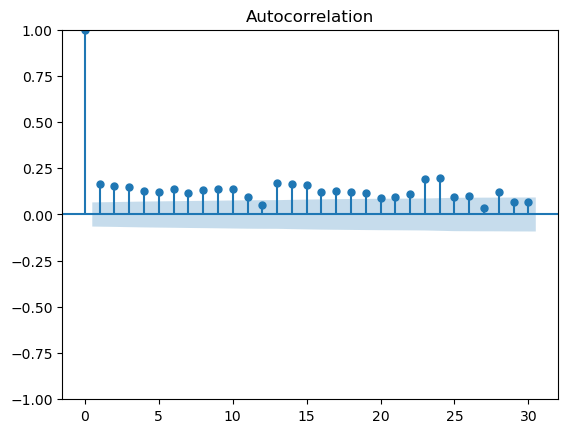

In [5]:
df_copy = df_copy.groupby("Posting Date").count()[["Id"]].rename(columns={"Id": "Vacancy_count"})

plot_acf(df_copy['Vacancy_count'])
plt.show()

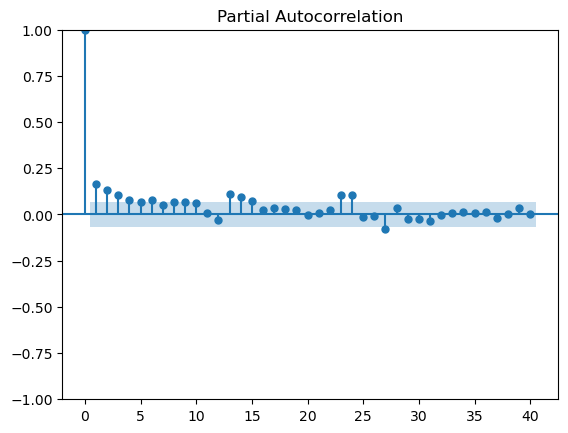

In [6]:
plot_pacf(df_copy["Vacancy_count"],lags=40)
plt.show()

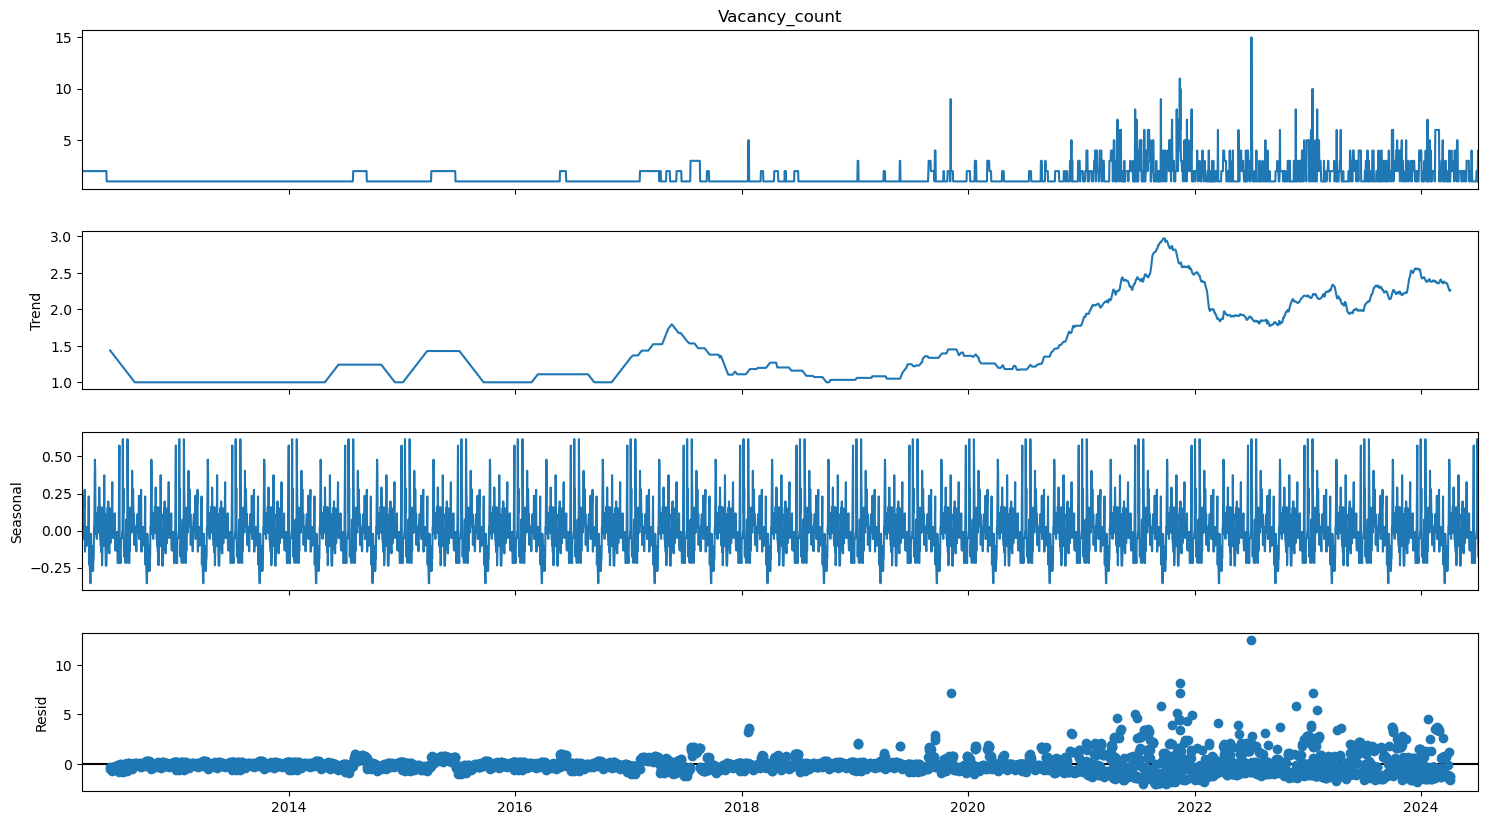

In [7]:
df_time = df_copy.asfreq('d',method="ffill")

decompose_result = seasonal_decompose(df_time['Vacancy_count'], period=182,model="additive")
decompose_result.plot().set_size_inches((16, 9))

plt.show()

In [8]:
dftest = adfuller(df_time["Vacancy_count"], autolag = 'AIC')
dfoutput = pd.Series(dftest [0:4], index = ['Test statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in dftest [4].items():
    dfoutput[f'Critical Value  % {key}'] = round(value,2)
    
print(dfoutput)

Test statistic                -5.832828e+00
p-value                        3.938552e-07
#Lags Used                     3.200000e+01
Number of Observations Used    4.472000e+03
Critical Value  % 1%          -3.430000e+00
Critical Value  % 5%          -2.860000e+00
Critical Value  % 10%         -2.570000e+00
dtype: float64


In [9]:
df_time.reset_index(inplace=True)
df_time.rename(columns={"Posting Date":"ds","Vacancy_count":"y"},inplace=True)

In [10]:
neural_prop = NeuralProphet()
neural_prop.fit(df_time,freq='D')

forecast = neural_prop.predict(df_time)
neural_prop.plot(forecast)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 70
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (71) is too small than the required number                     for the learning rate finder (241). The results might not be optimal.


Finding best initial lr:   0%|          | 0/241 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [11]:
def accuracy(y_true,y_pred):
    mape = round(mean_absolute_percentage_error(y_true,y_pred) *100,2)
    print(f"MSE {mean_absolute_error(y_true,y_pred)}")
    print(f"MSE {mean_squared_error(y_true,y_pred)}")
    print(f"MAPE {mape} %" )
    print(f"Accuracy {100-mape} %" )

In [12]:
y_pred = forecast["yhat1"][:len(df_time)]
y_true = df_time["y"]

accuracy(y_true,y_pred)

MSE 0.5064633522658184
MSE 0.8573486989297293
MAPE 28.64 %
Accuracy 71.36 %


In [13]:
future = neural_prop.make_future_dataframe(df_time, periods=182)
forecast = neural_prop.predict(future)

neural_prop.plot(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.451% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.451% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [14]:
# best_params=pmd.auto_arima(freq['y'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)
# best_params

In [15]:
sarima=SARIMAX(df_time['y'],order=(3,0,1),seasonal_order=(0,0,1,12))
predicted=sarima.fit().predict()
predicted

0       0.000000
1       1.786467
2       1.854959
3       1.876026
4       1.891690
          ...   
4500    1.914488
4501    1.915957
4502    1.476952
4503    1.776285
4504    2.793831
Name: predicted_mean, Length: 4505, dtype: float64

In [16]:
accuracy(y_true,predicted)

MSE 0.34000872573895163
MSE 0.5723867016420272
MAPE 20.27 %
Accuracy 79.73 %


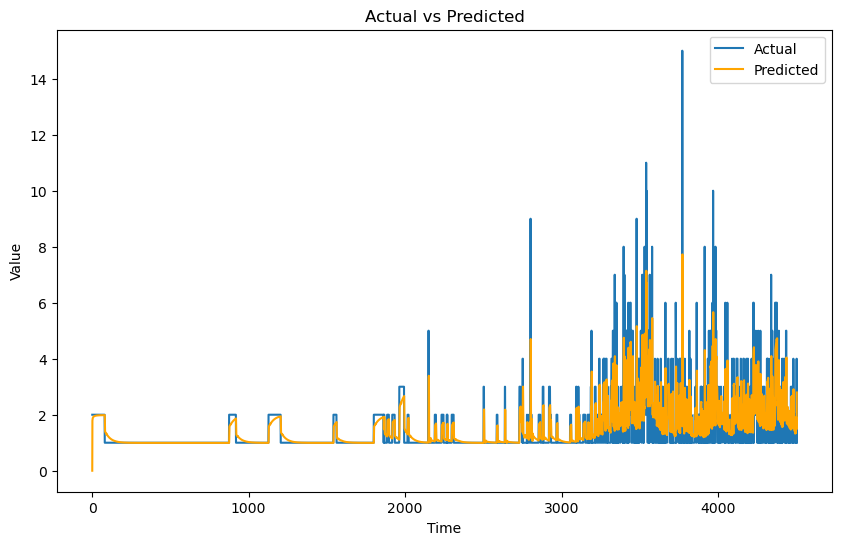

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual')
plt.plot(predicted, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [18]:
sarima = SARIMAX(df_time['y'], order=(3,0,1), seasonal_order=(0,0,1,12))
sarima_fit = sarima.fit()
forecast_steps = 180  

forecast = sarima_fit.get_forecast(steps=forecast_steps)

forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()


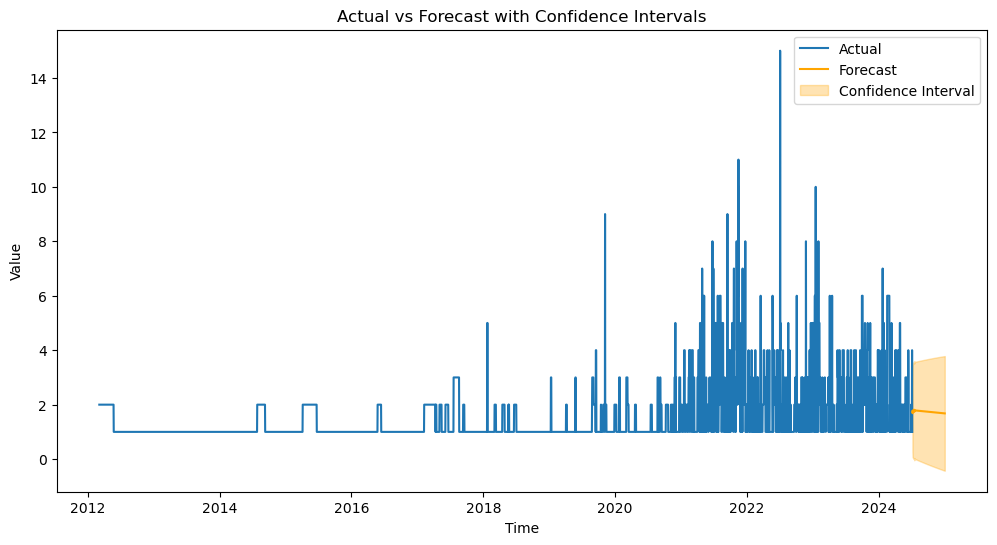

In [31]:
start_date = f"{df_copy.index.min()}".split(" ")[0]

dates = pd.date_range(start=start_date, periods=len(y_true), freq='D')
df_time.index = dates  

forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_dates = pd.date_range(start=dates[-1], periods=len(forecast_mean) + 1, freq='D')[1:]
forecast_mean.index = forecast_dates
forecast_conf_int.index = forecast_dates

plt.figure(figsize=(12, 6))
plt.plot(df_time.index, y_true, label='Actual')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')

plt.fill_between(forecast_mean.index,
                 forecast_conf_int.iloc[:, 0],  
                 forecast_conf_int.iloc[:, 1],  
                 color='orange', alpha=0.3, label='Confidence Interval')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Forecast with Confidence Intervals')
plt.legend()
plt.show()